# This notebook is a demonstration of running the combined peak ranging and peak ion identification ML models

Ryan Jacobs, based on original code from Jingrui Wei

Last updated: 6/18/25 by Ryan Jacobs


# Install and setup for Google Colab

In [1]:
# Link Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repo

!git clone https://github.com/uw-cmg/peak_detection

Cloning into 'peak_detection'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 575 (delta 57), reused 32 (delta 11), pack-reused 449 (from 1)
Receiving objects: 100% (575/575), 57.82 MiB | 27.94 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [3]:
# Install dependencies. Annoyingly takes about 5 minutes.

!pip install -r "peak_detection/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lmfit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [1]:
# For Colab, move repo directories so imports work

import shutil
shutil.move('peak_detection', 'peak_detection_repo')
shutil.move('peak_detection_repo/peak_detection', '.')

'./peak_detection'

# Import needed packages

In [1]:
!pip install pymatgen
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymatgen 2025.6.14 requires numpy<3,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26,

In [1]:
import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
import yaml
from pathlib import Path
import torch.nn.functional as F
import joblib
import matplotlib.colors as mcolors
from pymatgen.core import Composition
import pandas as pd

# Function definitions to do model predictions and visualization

In [15]:
def map01(ar):
    return (ar-ar.min()) / (ar.max()-ar.min())

def load_apt(apt_file):
    '''

    '''
    # Load the .apt file and get histogram
    d = apav.load_apt(apt_file)
    x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)
    spectrum_log = torch.tensor(map01(np.log(spectrum+1)), dtype=torch.float32)
    return spectrum, spectrum_log

def sort_predictions(peak_range_pred, elements):
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    inds = list(peak_range_pred[:, 0].argsort())
    inds = [int(i) for i in inds]
    elements_sort = [elements[i] for i in inds]
    return peak_range_pred_sort, elements_sort

def get_label_encoder():
    '''

    '''

    CHEMICAL_ELEMENTS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
                         'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
                         'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',
                         'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                         'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
                         'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir',
                         'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

    le = LabelEncoder()
    le.fit(CHEMICAL_ELEMENTS)
    return le

def get_RF_encoder(reduced_set=False, include_chargestates=False):
    if include_chargestates == False:
        if reduced_set == False:
            target_decoder = {0: 'Ag', 1: 'Al', 2: 'Ar', 3: 'As', 4: 'Au', 5: 'B', 6: 'Ba',
                              7: 'Be', 8: 'Bi', 9: 'Br', 10: 'C', 11: 'Ca', 12: 'Cd', 13: 'Ce',
                              14: 'Cl', 15: 'Co', 16: 'Cr', 17: 'Cs', 18: 'Cu', 19: 'Dy', 20: 'Er',
                              21: 'Eu', 22: 'F', 23: 'Fe', 24: 'Ga', 25: 'Gd', 26: 'Ge', 27: 'H',
                              28: 'He', 29: 'Hf', 30: 'Hg', 31: 'Ho', 32: 'I', 33: 'In', 34: 'Ir',
                              35: 'K', 36: 'Kr', 37: 'La', 38: 'Li', 39: 'Lu', 40: 'Mg', 41: 'Mn',
                              42: 'Mo', 43: 'N', 44: 'Na', 45: 'Nb', 46: 'Nd', 47: 'Ni', 48: 'O',
                              49: 'Os', 50: 'P', 51: 'Pb', 52: 'Pd', 53: 'Pr', 54: 'Pt', 55: 'Rb',
                              56: 'Re', 57: 'Rh', 58: 'Ru', 59: 'S', 60: 'Sb', 61: 'Sc', 62: 'Se',
                              63: 'Si', 64: 'Sm', 65: 'Sn', 66: 'Sr', 67: 'Ta', 68: 'Tb', 69: 'Te',
                              70: 'Th', 71: 'Ti', 72: 'Tl', 73: 'Tm', 74: 'U', 75: 'V', 76: 'W',
                              77: 'Xe', 78: 'Y', 79: 'Zn', 80: 'Zr'}
        else:
            target_decoder = {0: 'Ag', 1: 'Al', 2: 'Au', 3: 'C', 4: 'Ca', 5: 'Co', 6: 'Cu',
                              7: 'Fe', 8: 'Ga', 9: 'H', 10: 'Li', 11: 'Mg', 12: 'Mn', 13: 'Na',
                              14: 'Ni', 15: 'O', 16: 'Pd', 17: 'Pt', 18: 'S', 19: 'Sc', 20: 'Si',
                              21: 'Ti', 22: 'Zn', 23: 'Zr'}
    else:
        if reduced_set == False:
            raise ValueError('Not supported yet')
        else:
            target_decoder = {0: 'Ag1+',
                              1: 'Al1+', 2: 'Al2+', 3: 'Al3+', 4: 'Au1+', 5: 'Au2+', 6: 'C1+',
                              7: 'C2+', 8: 'Ca1+', 9: 'Ca2+', 10: 'Co1+', 11: 'Co2+', 12: 'Cu1+',
                              13: 'Cu2+', 14: 'Fe1+', 15: 'Fe2+', 16: 'Fe3+', 17: 'Ga1+', 18: 'Ga2+',
                              19: 'H1+', 20: 'Li1+', 21: 'Li2+', 22: 'Mg1+', 23: 'Mg2+', 24: 'Mn1+',
                              25: 'Mn2+', 26: 'Na1+', 27: 'Ni1+', 28: 'Ni2+', 29: 'O1+', 30: 'O2+',
                              31: 'Pd1+', 32: 'Pd2+', 33: 'Pt1+', 34: 'Pt2+', 35: 'S1+', 36: 'S2+',
                              37: 'Sc1+', 38: 'Sc2+', 39: 'Si1+', 40: 'Si2+', 41: 'Ti1+', 42: 'Ti2+',
                              43: 'Zn1+', 44: 'Zn2+', 45: 'Zr1+', 46: 'Zr2+'}
    return target_decoder

def predict_elements(model, spectrum, label_encoder, device):
    '''

    '''
    model.eval()
    with torch.no_grad():
        spectrum = torch.FloatTensor(spectrum).unsqueeze(0).to(device)
        outputs = model(spectrum, lengths = [spectrum.shape[1]])

        probabilities = F.softmax(outputs, dim=2)
        predictions = torch.argmax(outputs, dim=2)

        # Convert numerical predictions to element names
        element_predictions = label_encoder.inverse_transform(predictions.cpu().numpy().ravel())
        confidence_scores = torch.max(probabilities, dim=2)[0].cpu().numpy().ravel()

        return element_predictions, confidence_scores

def plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    plt.clf()
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # set the zoom in m/c range
    bin_width = 0.01
    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] >plot_min)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Plot the spectrum
    x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

    ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    for start, end in peak_pred_:
        ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
    for start, end in peak_pred_:
        ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
        ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

    # Set labels and title
    ax.set_xlabel('Mass to charge ratio (Da)')
    ax.set_ylabel('Intensity in log scale normalized (counts)')

    ax.set_xlim(-2, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    ax.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    plt.legend()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def predict_peak_ranges(apt_file, conf=0.02, iou=0.01, max_det=2000):
    '''

    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # Load in the RangingNN model and do the peak detection
    cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
    cfg = yaml.safe_load(Path(cfg).read_text())

    cfg['iou'] = iou
    cfg['conf'] = conf
    cfg['max_det'] = max_det

    modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights/best.pt') # loading the default trained-model in the package
    predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = 'test_results', cfg = cfg)
    result = predictor()[0]
    peak_range_pred = result[:,:2].cpu()
    counts = result[:,2].cpu()

    print('model predicted peaks:',peak_range_pred.shape[0])

    return peak_range_pred, counts

def predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5):
    '''
    Certain wide ranges due to the tail leads to over-high indensity,
    shrinking the other intensities, so set limit here
    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    profile = np.zeros_like(peak_range_pred)
    peak_range_pred = np.asarray(peak_range_pred)

    # Preprocess detected peak ranging data for IonClassifier model
    for k in range(profile.shape[0]):
        profile[k][0] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][1])+1].argmax()
        profile[k][0] = (profile[k][0] + round(peak_range_pred[k][0]))/100

        window = min(max_width_Da/bin_width, round(peak_range_pred[k][1])+1-round(peak_range_pred[k][0]))
        profile[k][1] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][0]+window)].sum()

    profile[:,1] = (profile[:,1] - profile[:,1].min() ) / (profile[:,1].max() - profile[:,1].min()) # normalize counts from one spectrum to 0-1

    # Make sure the profile is in sequential order, increasing m/c
    profile_final = profile[profile[:, 0].argsort()]

    # Run the IonClassifier model to predict the peak IDs
    model_path = os.path.join(os.path.dirname(peak_detection.__file__), 'Ionclassifier/modelweights')
    RNNmodel = torch.load(os.path.join(model_path, 'model_bestepoch.tar'), map_location='cpu')['ema']
    le = get_label_encoder()
    res, confidence = predict_elements(RNNmodel, profile_final, le, 'cpu')

    return res, confidence, profile_final

def predict_peak_ions_RF(peak_range_pred, counts, model_name='original'):
    '''
    Use in-development Random forest model for ion peak IDs

    model_name = 'original' or 'reducedset_peakneighbors2' or 'reducedset'
    '''

    if model_name == 'original':
        reduced_set=False
        include_chargestates = False
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier.pkl'
    elif model_name == 'reducedset':
        reduced_set=True
        include_chargestates = False
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset.pkl'
    elif model_name == 'reducedset_chgstate':
        reduced_set=True
        include_chargestates = True
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset_chgstate.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset_chgstate.pkl'
    elif model_name == 'reducedset_peakneighbors2':
        reduced_set=True
        include_chargestates = False
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset_peakneighbors2.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset_peakneighbors2.pkl'
    elif model_name == 'reducedset_peakneighbors5':
        reduced_set=True
        include_chargestates = False
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset_peakneighbors5.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset_peakneighbors5.pkl'

    scaler = joblib.load(scaler_path)
    model = joblib.load(model_path)

    X_0 = 0.01*peak_range_pred[:, 0]
    X_1 = counts

    # If using model with peakneighbors2, there are numerous peak ratio features that need to be built
    if model_name == 'reducedset_peakneighbors2' or model_name == 'reducedset_peakneighbors5':
        # Build the features
        # X_0 = m/c, X_1 = counts
        if model_name == 'reducedset_peakneighbors2':
            peak_ratio_neighbor_width = 2
            max_peaks = 13
        elif model_name == 'reducedset_peakneighbors5':
            peak_ratio_neighbor_width = 5
            max_peaks = 21
        ratios = list()
        for i, count1 in enumerate(X_1):
            ratio_row = list()
            for j, count2 in enumerate(X_1):
                ratio = count1 / count2
                dist = abs(X_0[j] - X_0[i])
                if dist <= peak_ratio_neighbor_width:
                    ratio_row.append(ratio)
            ratios.append(ratio_row)
        # Pad the ratio rows
        for i, lst in enumerate(ratios):
            while len(ratios[i]) < max_peaks:
                ratios[i].append(-10000000)
        X = np.column_stack((X_0, X_1, ratios))
    else:
        X = np.column_stack((X_0, X_1))

    print(X.shape)
    print(X)

    X_norm = scaler.transform(X)

    preds = model.predict_proba(X_norm)

    target_decoder = get_RF_encoder(reduced_set=reduced_set, include_chargestates=include_chargestates)

    elements = list()
    second_elements = list()
    confs = list()
    second_confs = list()
    for pred in preds:
        element = target_decoder[pred.argsort()[-1]]
        conf = pred[pred.argsort()[-1]]
        elements.append(element)
        confs.append(conf)

        second_element = target_decoder[pred.argsort()[-2]]
        second_conf = pred[pred.argsort()[-2]]
        if second_conf > 0.0:
          second_elements.append(second_element)
        else:
          second_elements.append('NaN')
        second_confs.append(second_conf)

    return elements, second_elements, confs, second_confs

def plot_predictions_NEW(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    colors = list(mcolors.TABLEAU_COLORS.values())
    color_inds = [int(np.random.uniform(0, len(colors))) for _ in range(peak_range_pred.shape[0])]

    plt.clf()
    plt.figure(figsize=(10, 6))
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    x = np.linspace(0.0, spectrum_log.shape[0]*0.01, spectrum_log.shape[0])
    plt.plot(x, spectrum_log)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] > plot_min)]

    count = 0
    for start, end in peak_pred_:
        plt.axvspan(start*0.01, end*0.01, alpha=0.3, color=colors[color_inds[count]])
        plt.axvline(start*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        plt.axvline(end*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        count += 1

    # Set labels and title
    plt.xlabel('Mass to charge ratio (Da)')
    plt.ylabel('Intensity in log scale normalized (counts)')

    plt.xlim(0.01*plot_min, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    plt.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
                    #plt.text(0.01*float(peak_start)+0.02, 1.0, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                #plt.text(0.01*float(peak_start)+0.02, 1.05, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def calculate_iou_1d(interval1, interval2):
    """
    Calculates the Intersection over Union (IoU) of two 1D intervals.

    Args:
        interval1: A tuple or list of two numbers representing the start and end of the first interval.
        interval2: A tuple or list of two numbers representing the start and end of the second interval.

    Returns:
        The IoU of the two intervals, a float between 0 and 1.
    """

    start1, end1 = interval1
    start2, end2 = interval2

    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)

    intersection_length = max(0, intersection_end - intersection_start)

    union_length = (end1 - start1) + (end2 - start2) - intersection_length

    if union_length == 0:
        return 0.0

    iou = intersection_length / union_length
    return iou

def evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2):
    multiplier = 0.01
    iou_thresh = 0.1
    num_found = 0
    num_true = len(rng)
    num_pred = peak_range_pred_sort.shape[0]
    true_elements = list()
    pred_elements = list()
    pred_elements2 = list()
    is_found = list()
    true_found_elements = list()
    pred_found_elements1 = list()
    pred_found_elements2 = list()
    true_start = list()
    true_end = list()
    for _, i in enumerate(rng):
        start = i.lower
        end = i.upper
        ious = list()
        true_start.append(start)
        true_end.append(end)
        for __, j in enumerate(peak_range_pred_sort):
            iou = calculate_iou_1d((start, end), (multiplier*float(j[0]), multiplier*float(j[1])))
            ious.append(iou)
        # Find the index with max iou
        iou_max_ind = np.where(np.array(ious)==max(np.array(ious)))[0][0]
        max_iou = ious[iou_max_ind]
        if max_iou >= iou_thresh:
            #print('Found peak', i, 'with true ion', i.hill_formula, 'and predicted ion', elements_sort[iou_max_ind], 'or', elements_sort2[iou_max_ind])
            num_found += 1
            is_found.append(True)
            true_found_elements.append(i.hill_formula)
            pred_found_elements1.append(elements_sort[iou_max_ind])
            true_elements.append(i.hill_formula)
            pred_elements.append(elements_sort[iou_max_ind])
            if elements_sort2 is not None:
                pred_elements2.append(elements_sort2[iou_max_ind])
                pred_found_elements2.append(elements_sort2[iou_max_ind])
            else:
                pred_elements2.append(None)
                pred_found_elements2.append('NaN')
        else:
            is_found.append(False)
            true_found_elements.append('NaN')
            pred_found_elements1.append('NaN')
            pred_found_elements2.append('NaN')
            #print('No peak found for', i)

    # These are statistics of finding peaks in the right place (i.e., ranging)
    #print(num_true, num_pred, num_found)
    prec = num_found/num_pred
    recall = num_found/num_true
    f1 = 2*prec*recall/(prec+recall)
    #print(prec, recall, f1)

    # Of the peaks that are found in the right positions, quantify the ion classification accuracy
    num_correct = 0
    num_found_molecule = num_found
    for true, pred, pred2 in zip(true_elements, pred_elements, pred_elements2):
        # Need to strip out numbers and + signs if pred elements have charge states. Just match the element type for now
        import re
        def remove_numbers_and_plus(s):
            # Use regex to remove digits and plus signs
            return re.sub(r'[0-9+]', '', s)
        true = Composition(true).reduced_formula
        pred = Composition(remove_numbers_and_plus(pred)).reduced_formula
        pred2 = Composition(remove_numbers_and_plus(pred2)).reduced_formula
        print(true, pred, pred2)
        # for molecules, just consider one of the host elements as being correct for now
        if true == pred or true == pred2:
            num_correct += 1
            #print('found match', true, pred, pred2)
        # Remove the molecules for now
        elif len(true) > 2 or '2' in true or '3' in true or '4' in true:
            num_found_molecule -= 1
            #print('found molecule to ignore', true, pred)
        else:
            #print('No match for', true, pred, pred2)
            pass

    acc = num_correct/num_found
    acc_nomol = num_correct/num_found_molecule
    #print(acc)

    return prec, recall, f1, acc, acc_nomol, is_found, true_found_elements, true_start, true_end, true_elements, pred_found_elements1, pred_found_elements2

# Run the peak detection and NN ion classifier together

INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  73.3ms inference, 3.4ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


<Figure size 640x480 with 0 Axes>

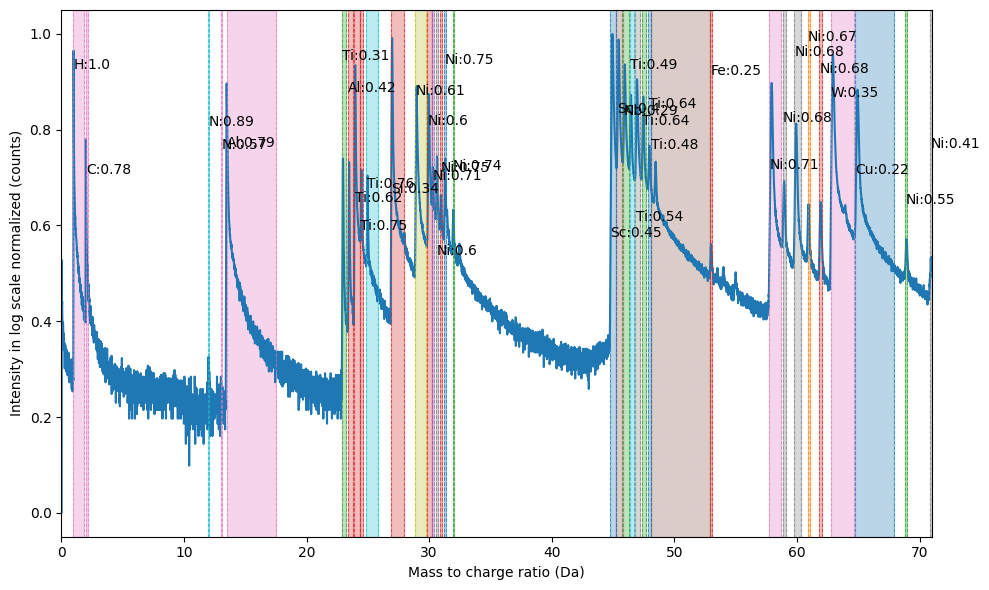

In [ ]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses Jingrui's NN model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

res, confidence, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

#plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=2000, resort=True)

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=res,
                 confidence=confidence,
                 plot_min=0,
                 plot_max=7100,
                 resort=True)


# Run the peak detection and RF ion classifier together

In [3]:
# Need to git clone peak_detection_extra to get large RF model file
!git clone https://github.com/uw-cmg/peak_detection_extra

Cloning into 'peak_detection_extra'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 6), reused 22 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 6.87 MiB | 9.63 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Filtering content: 100% (8/8), 1011.31 MiB | 41.52 MiB/s, done.


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  95.9ms inference, 4.8ms postprocess for per spectrum 
model predicted peaks: 36


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


(36, 2)
[[2.88720455e+01 5.58992662e-02]
 [5.88201370e+01 5.70571832e-02]
 [5.77286911e+01 5.77498488e-02]
 [4.80819817e+01 5.78042977e-02]
 [3.19125576e+01 6.59321696e-02]
 [9.56757128e-01 8.06479529e-02]
 [5.29209747e+01 8.08929130e-02]
 [2.43640842e+01 8.47111493e-02]
 [2.33880100e+01 9.84975845e-02]
 [6.47131348e+01 1.06100872e-01]
 [7.08404312e+01 1.11134686e-01]
 [1.30210352e+01 1.17624462e-01]
 [2.68852978e+01 1.32170737e-01]
 [4.52726440e+01 1.37854069e-01]
 [3.08916454e+01 1.52120367e-01]
 [6.18054276e+01 1.70512497e-01]
 [1.35167284e+01 1.92040280e-01]
 [1.19943132e+01 1.92977041e-01]
 [6.08553352e+01 2.35114500e-01]
 [3.12309780e+01 2.67076880e-01]
 [2.38991165e+01 3.73952001e-01]
 [4.63809738e+01 4.21531051e-01]
 [4.68137207e+01 4.38310891e-01]
 [4.47772026e+01 4.51525837e-01]
 [2.98587570e+01 4.54518497e-01]
 [6.88413544e+01 4.99169707e-01]
 [5.97449684e+01 5.10838926e-01]
 [2.48905659e+01 6.84865177e-01]
 [1.99239910e+00 6.91503048e-01]
 [2.28998756e+01 6.98664546e-01]
 [

<Figure size 640x480 with 0 Axes>

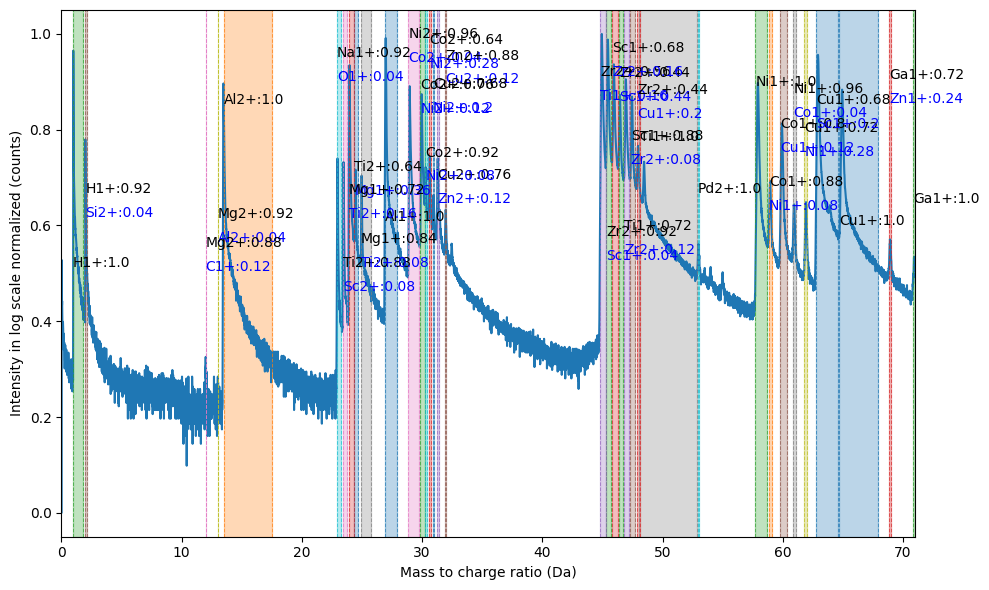

In [5]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses in-development Random forest model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred,
                                                                      counts,
                                                                      model_name='reducedset_chgstate')

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=elements,
                 confidence=confs,
                 plot_min=0,
                 plot_max=7100,
                 resort=False,
                 res2=second_elements,
                 confidence2=second_confs)

# Run evaluation over all files for both models


INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
**************************
Start inference
Speed:  110.7ms inference, 4.7ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36
H2 H2 NaN
H2 C NaN
Al Al NaN
Al Si NaN
Ti Ti NaN
Ti Al NaN
Ti Ti NaN
Ti Ti NaN
Ti Ti NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Zr Ni NaN
Zr Ni NaN
Zr Ni NaN
Zr Ni NaN
Zr Ni NaN
Zr Sc NaN
Zr Nb NaN
Zr Ti NaN
Zr Ti NaN
ZrH Sc NaN
ZrH Ti NaN
ZrH Ti NaN
Cu W NaN
Cu Cu NaN
Ga Ni NaN
Ga Ni NaN
Co Ni NaN
C N2 NaN
Peak finding results
0.9166666666666666 0.9705882352941176 0.9428571428571428


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


(36, 2)
[[9.56757128e-01 8.06479529e-02]
 [1.99239910e+00 6.91503048e-01]
 [1.19943132e+01 1.92977041e-01]
 [1.30210352e+01 1.17624462e-01]
 [1.35167284e+01 1.92040280e-01]
 [2.28998756e+01 6.98664546e-01]
 [2.33880100e+01 9.84975845e-02]
 [2.38991165e+01 3.73952001e-01]
 [2.43640842e+01 8.47111493e-02]
 [2.48905659e+01 6.84865177e-01]
 [2.68852978e+01 1.32170737e-01]
 [2.88720455e+01 5.58992662e-02]
 [2.98587570e+01 4.54518497e-01]
 [3.02467518e+01 7.38616765e-01]
 [3.05737686e+01 7.59302616e-01]
 [3.08916454e+01 1.52120367e-01]
 [3.12309780e+01 2.67076880e-01]
 [3.19125576e+01 6.59321696e-02]
 [4.47772026e+01 4.51525837e-01]
 [4.52726440e+01 1.37854069e-01]
 [4.58301010e+01 7.92186439e-01]
 [4.63809738e+01 4.21531051e-01]
 [4.68137207e+01 4.38310891e-01]
 [4.73368454e+01 7.78903127e-01]
 [4.78808670e+01 8.07407498e-01]
 [4.80819817e+01 5.78042977e-02]
 [5.29209747e+01 8.08929130e-02]
 [5.77286911e+01 5.77498488e-02]
 [5.88201370e+01 5.70571832e-02]
 [5.97449684e+01 5.10838926e-01]
 [

INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R15_72243.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/data_from_David/R15_72243.apt drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG
**************************
Start inference
Speed:  138.9ms inference, 4.3ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R15_72243.apt


model predicted peaks: 16
Fe Mn NaN
Fe V NaN
Fe O2 NaN
Cu Sc NaN
Cu C NaN
Cu N2 NaN
Cu Sc NaN
C C NaN
C N2 NaN
Si C NaN
O2 N2 NaN
C C NaN
C O2 NaN
H2 H2 NaN
CN C NaN
Peak finding results
0.9375 0.8823529411764706 0.9090909090909091


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R15_72243.apt


(16, 2)
[[9.9328047e-01 7.4212469e-02]
 [5.9735441e+00 5.7490379e-01]
 [1.1966282e+01 5.5361885e-01]
 [1.3972656e+01 1.0459318e-01]
 [1.5964952e+01 1.6295432e-01]
 [1.7980822e+01 4.8466125e-01]
 [1.8620892e+01 2.7895397e-01]
 [2.3970249e+01 6.1386660e-02]
 [2.5982510e+01 8.7606862e-02]
 [2.6887960e+01 2.1798775e-01]
 [2.7823978e+01 1.0605970e-01]
 [2.8909210e+01 1.7928565e-01]
 [3.1406651e+01 4.4377351e-01]
 [3.2404045e+01 2.3802704e-01]
 [6.2858513e+01 4.7375154e-01]
 [6.4817360e+01 6.7670844e-02]]
Fe Fe Si
Fe Al Mn
Fe Fe NaN
Cu Cu Ga
Cu Cu Co
Cu Cu Zn
Cu Cu Zn
C C H2
C Mg NaN
Si Si Al
O2 O2 S
C Mg Ti
C Fe Ag
H2 H2 NaN
CN Mg NaN
Jingrui NN Ion classification results
0.2 0.21428571428571427
Random Forest Ion classification results
0.6666666666666666 0.6666666666666666


INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG
**************************
Start inference
Speed:  114.3ms inference, 7.2ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt


model predicted peaks: 58
Zn Zn NaN
Zn Zn NaN
Zn Na NaN
Zn Zn NaN
Zn Zn NaN
Zn Zn NaN
Zn Zn NaN
Zn Zn NaN
Cu Cu NaN
Cu Zn NaN
Cu N2 NaN
Cu N2 NaN
Ag Pd NaN
Ag Pd NaN
Au Au NaN
Au Au NaN
Ga Zn NaN
H2Au Bi NaN
Si N2 NaN
Si N2 NaN
Si N2 NaN
Al C NaN
Al C NaN
AuN Ir NaN
AuN2 Th NaN
ZnAu Th NaN
ZnAu Th NaN
ZnAu Th NaN
Zr N2 NaN
Zr N2 NaN
Zr N2 NaN
Zr N2 NaN
Zr P NaN
Zr P NaN
Zr P NaN
Zr P NaN
Na Be NaN
Mg N2 NaN
Mg B NaN
Ca Be NaN
Ca Be NaN
N2 C NaN
N2O Al NaN
Pd Rb NaN
Pd Y NaN
Pd Nb NaN
Pd Nb NaN
Pd Nb NaN
Pt Br NaN
Pt Au NaN
Pt Au NaN
H4AuO Au NaN
H2 H2 NaN
H2 C NaN
H2O2 O2 NaN
H2O O2 NaN
Peak finding results
0.9655172413793104 0.9655172413793104 0.9655172413793104


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt


(58, 2)
[[1.00159514e+00 7.47714520e-01]
 [2.00959539e+00 5.04702568e-01]
 [1.19740486e+01 5.62086701e-01]
 [1.24759979e+01 1.16442345e-01]
 [1.34714794e+01 4.89495069e-01]
 [1.39523535e+01 5.57601266e-02]
 [1.44695110e+01 7.58044720e-01]
 [1.49711447e+01 7.04360157e-02]
 [1.69869556e+01 2.70175308e-01]
 [1.80023041e+01 2.58152783e-01]
 [1.99536877e+01 1.99370533e-01]
 [2.19579811e+01 4.07891542e-01]
 [2.29567776e+01 9.33754966e-02]
 [2.69298229e+01 1.60597622e-01]
 [2.79841347e+01 1.41984120e-01]
 [2.99340992e+01 5.10434091e-01]
 [3.02695980e+01 6.36690110e-02]
 [3.06080360e+01 1.72507063e-01]
 [3.12657375e+01 3.99328470e-01]
 [3.13764668e+01 5.98964989e-01]
 [3.18959999e+01 5.32041907e-01]
 [3.23757019e+01 1.50710583e-01]
 [3.29078255e+01 5.20452112e-02]
 [3.33660698e+01 1.05365038e-01]
 [3.48826370e+01 1.89302176e-01]
 [4.38822441e+01 1.57125130e-01]
 [4.48933525e+01 3.71103942e-01]
 [4.54072266e+01 4.11434293e-01]
 [4.58957100e+01 1.36546299e-01]
 [4.68431931e+01 7.41543397e-02]
 [

INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG
**************************
Start inference
Speed:  91.4ms inference, 1.7ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt


model predicted peaks: 8
Al N2 NaN
Al F2 NaN
H2 H2 NaN
H2 C NaN
Al2O N2 NaN
Peak finding results
0.625 1.0 0.7692307692307693


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt


(8, 2)
[[ 1.1772608   0.51757586]
 [ 2.1288178   0.11356733]
 [ 2.3308418   0.05186031]
 [13.224958    0.1332994 ]
 [23.297045    0.05340726]
 [25.640959    0.1205167 ]
 [29.445375    0.06304538]
 [46.31731     0.09235944]]
Al Mg C
Al Mg NaN
H2 H2 NaN
H2 Li NaN
Al2O Ti NaN
Jingrui NN Ion classification results
0.2 0.3333333333333333
Random Forest Ion classification results
0.2 0.3333333333333333


INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG
**************************
Start inference
Speed:  89.2ms inference, 8.7ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt


model predicted peaks: 75
Li N2 NaN
Li O2 NaN
O2 N2 NaN
Mn Mn NaN
Mn Cl2 NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Ni Ni NaN
Co Ni NaN
Co Ni NaN
NiO Se NaN
NiO Se NaN
NiO Se NaN
NiO Ni NaN
NiO Ge NaN
NiO Ge NaN
NiO K NaN
NiO Na NaN
CoO Se NaN
CoO Ge NaN
Ni2O Ba NaN
Ni2O Ni NaN
Ni2O Ba NaN
Ni2O Mn NaN
NiO2 Zr NaN
NiO2 Zr NaN
NiO2 P NaN
CoO2 Zr NaN
MnO2 Sr NaN
MnO2 P NaN
MnO3 Pd NaN
MnO3 Cl2 NaN
O2 Cu NaN
O2 F2 NaN
H2O2 N2 NaN
H2O O2 NaN
NiO3 Pd NaN
CoO3 Y NaN
MnO Mn NaN
MnO4 Ru NaN
MnHO3 Cl2 NaN
H2 C NaN
H2 C NaN
H2 N2 NaN
Peak finding results
0.6666666666666666 0.819672131147541 0.7352941176470588


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt


(75, 2)
[[4.57438976e-02 9.40398574e-02]
 [1.03525126e+00 6.23645149e-02]
 [2.00117779e+00 1.14918359e-01]
 [3.01870894e+00 3.11490595e-01]
 [6.00670719e+00 1.08692244e-01]
 [6.99672222e+00 1.93950042e-01]
 [1.59604416e+01 4.41524833e-01]
 [1.69617615e+01 7.31647849e-01]
 [1.79690208e+01 2.88680851e-01]
 [1.89853706e+01 8.90109986e-02]
 [1.99671974e+01 8.50048512e-02]
 [2.69671192e+01 1.03871889e-01]
 [2.74359131e+01 9.44274962e-02]
 [2.84450455e+01 6.46248162e-02]
 [2.88977623e+01 6.06306344e-02]
 [2.94075584e+01 7.95428574e-01]
 [2.99213600e+01 1.68834478e-01]
 [3.04300289e+01 5.53068891e-02]
 [3.09054184e+01 3.28142524e-01]
 [3.19221134e+01 9.22397897e-02]
 [3.39514122e+01 7.08126426e-02]
 [3.54008446e+01 6.90478310e-02]
 [3.59281731e+01 5.19496165e-02]
 [3.64509010e+01 1.52941599e-01]
 [3.69030762e+01 1.28905565e-01]
 [3.74257431e+01 7.67553747e-02]
 [3.79105225e+01 5.27287945e-02]
 [3.84327087e+01 1.92809939e-01]
 [3.89276810e+01 1.30502835e-01]
 [3.94366913e+01 1.06952697e-01]
 [

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

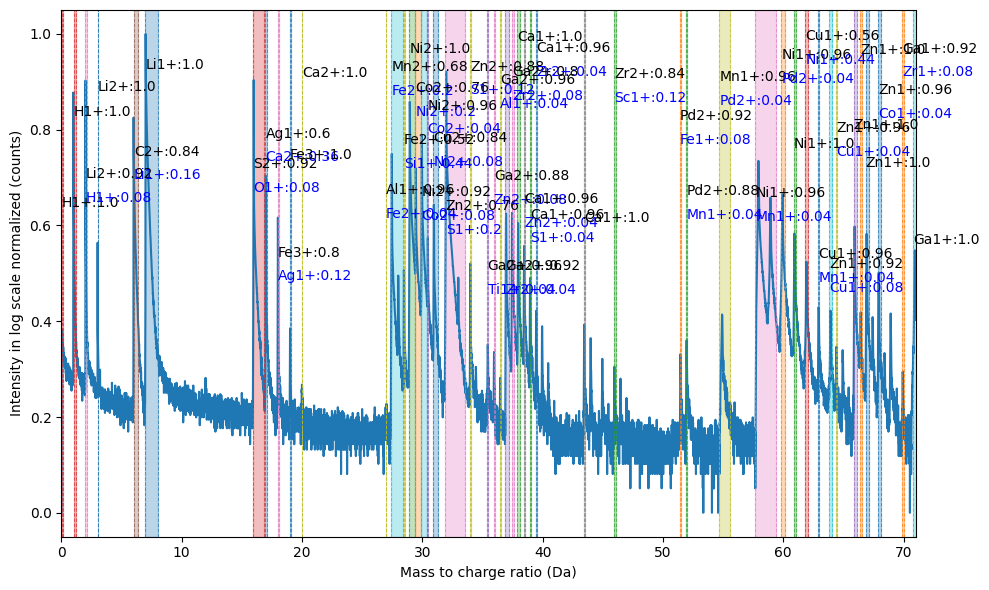

In [21]:

apt_files = ['drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt',
              'drive/MyDrive/Cameca/data_from_David/R15_72243.apt',
             'drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt',
              'drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt',
              'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt']

rrng_files = ['drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG',
             'drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG',
             'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG']

for apt_file, rrng in zip(apt_files, rrng_files):
    results = dict()
    print('**************************')
    print('ANALYZING FILE', apt_file, rrng)
    print('**************************')
    rng = apav.load_rrng(rrng)

    # Get peak ranges
    peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

    # Do Jingrui NN classification
    elements_sort_NN, confidence_NN, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

    # Sort preds. For NN, the elements are already sorted
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    #peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, res)
    elements_sort2 = ['NaN' for i in elements_sort_NN]

    # Evaluate preds
    prec, recall, f1, acc_NN, acc_NN_nomol, is_found, true_found_elements, true_start, true_end, true_elements, pred_found_elements1_NN, pred_found_elements2 = evaluate_predictions(rng, peak_range_pred_sort, elements_sort_NN, elements_sort2)

    print('Peak finding results')
    print(prec, recall, f1)


    # Do RF classification
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    counts_sort = counts[peak_range_pred[:, 0].argsort()]
    elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred_sort, counts_sort, model_name='reducedset_chgstate') #_peakneighbors2
    #elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred, counts, model_name='reducedset_peakneighbors5') #_peakneighbors2

    # Sort preds
    #peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, elements)
    #peak_range_pred_sort, elements_sort2 = sort_predictions(peak_range_pred, second_elements)
    elements_sort = elements
    elements_sort2 = second_elements

    # Evaluate preds
    prec, recall, f1, acc_RF, acc_RF_nomol, is_found, true_found_elements, true_start, true_end, true_elements, pred_found_elements1, pred_found_elements2 = evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2)

    results['Peak range true value, start'] = true_start
    results['Peak range true value, end'] = true_end
    results['Peak found?'] = is_found
    results['True ions found'] = true_found_elements
    results['Pred ions found (Jingrui NN)'] = pred_found_elements1_NN
    results['Pred ions found (Random forest) element1'] = pred_found_elements1
    results['Pred ions found (Random forest) element2'] = pred_found_elements2

    results['Peak find precision'] = [prec]
    results['Peak find recall'] = [recall]
    results['Peak find F1'] = [f1]

    results['Peak range prediction, start'] = np.array(peak_range_pred_sort[:,0])/100
    results['Peak range prediction, end'] = np.array(peak_range_pred_sort[:,1])/100
    results['Peak range prediction, counts'] = np.array(counts)

    results['Ion classification (Jingrui NN)'] = elements_sort_NN
    results['Ion classification confidence (Jingrui NN)'] = confidence_NN
    results['Ion classification accuracy (Jingrui NN)'] = [acc_NN]
    results['Ion classification accuracy without molecules (Jingrui NN)'] = [acc_NN_nomol]

    results['Ion classification (Random forest)'] = elements_sort
    results['Ion classification confidence (Random forest)'] = confs
    results['Ion classification 2nd choice (Random forest)'] = elements_sort2
    results['Ion classification 2nd choice confidence (Random forest)'] = second_confs
    results['Ion classification accuracy (Random forest)'] = [acc_RF]
    results['Ion classification accuracy without molecules (Random forest)'] = [acc_RF_nomol]

    print('Jingrui NN Ion classification results')
    print(acc_NN, acc_NN_nomol)

    print('Random Forest Ion classification results')
    print(acc_RF, acc_RF_nomol)

    results_df = pd.DataFrame().from_dict(results, orient='index').T
    results_df.to_csv(apt_file.split('/')[-1]+'_results.csv', index=False)

    plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred_sort,
                 res=elements_sort,
                 confidence=confs,
                 plot_min=0,
                 plot_max=7100,
                 resort=False,
                 res2=elements_sort2,
                 confidence2=second_confs)



In [ ]:
#for i, j, l, k in zip(peak_range_pred_sort*0.01, elements, second_elements, true_elements):
for i, j, l, k in zip(peak_range_pred_sort*0.01, elements_sort, elements_sort2, true_elements):

  print(i, j, l, k)

tensor([0.9568, 1.8408]) H NaN H
tensor([1.9924, 2.1567]) H NaN H2
tensor([11.9943, 12.0545]) Mg C Al
tensor([13.0210, 13.0725]) Mg Al Al
tensor([13.5167, 17.5184]) Al NaN Ti
tensor([22.8999, 23.2390]) Na NaN Ti
tensor([23.3880, 23.7533]) Ti Sc Ti
tensor([23.8991, 24.3431]) Mg Ti Ti
tensor([24.3641, 24.6395]) Ti Mg Ti
tensor([24.8906, 25.7970]) Mg Ti Ni
tensor([26.8853, 27.9101]) Al NaN Ni
tensor([28.8720, 29.7683]) Ni Co Ni
tensor([29.8588, 30.2156]) Co Ni Ni
tensor([30.2468, 30.4006]) Co Ni Ni
tensor([30.5738, 30.7568]) Co Ni Ni
tensor([30.8916, 31.0374]) Cu Ni Zr
tensor([31.2310, 31.3785]) Cu Ni Zr
tensor([31.9126, 32.0279]) Zn Cu Zr
tensor([44.7772, 45.2771]) Zr Ti Zr
tensor([45.2726, 45.7567]) Zr Sc Zr
tensor([45.8301, 46.2831]) Sc Zr Zr
tensor([46.3810, 46.7091]) Sc Zr Zr
tensor([46.8137, 47.1920]) Ti Sc Zr
tensor([47.3368, 47.7018]) Sc Zr Zr
tensor([47.8809, 48.1308]) Zr Sc HZr
tensor([48.0820, 52.8780]) Ti Zr HZr
tensor([52.9210, 53.0316]) Pd Ti HZr
tensor([57.7287, 58.7121]) N